In [1]:
from config import DATA_DIR, RANDOM_SEED, NUM_WORKERS
from data_loading import set_seed, get_svhn_for_eda, compute_channel_stats, class_distribution
from visualization import show_examples_per_class, plot_channel_histograms, plot_split_distributions, compute_brightness_contrast_sharpness, plot_brightness_contrast_sharpness, plot_class_means, channel_correlations

set_seed(RANDOM_SEED)

train_eda, test_eda = get_svhn_for_eda(str(DATA_DIR))
print(f"Train size: {len(train_eda)}, test size: {len(test_eda)}")

Train size: 73257, test size: 26032


In [2]:

x0, _ = train_eda[0]
print("Sample shape (C,H,W):", tuple(x0.shape))

Sample shape (C,H,W): (3, 32, 32)


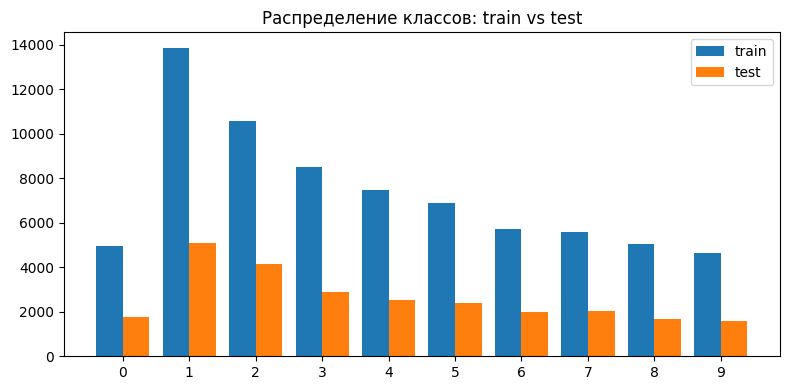

In [4]:
plot_split_distributions(train_eda, test_eda)

Видно, что частые цифры преобладают над редкими. Это говорит о том, что в обучении надо будет контролировать метрики по классам и при необходимости использовать class weighting

Формы train и test похожи друг на друга, без сильных сдвигов, сильного сдвига по меткам между выборками нет

In [5]:
mean, std = compute_channel_stats(train_eda, batch_size=512, num_workers=NUM_WORKERS)
print("Train channel mean:", mean)
print("Train channel std:", std)

Train channel mean: [0.4381933808326721, 0.4442710876464844, 0.47324609756469727]
Train channel std: [0.19797302782535553, 0.20089592039585114, 0.19671489298343658]


In [7]:
mean, std = compute_channel_stats(test_eda, batch_size=512, num_workers=NUM_WORKERS)
print("Test channel mean:", mean)
print("Test channel std:", std)

Test channel mean: [0.4524315595626831, 0.4524875581264496, 0.4689635932445526]
Test channel std: [0.2191089540719986, 0.22625242173671722, 0.2281615436077118]


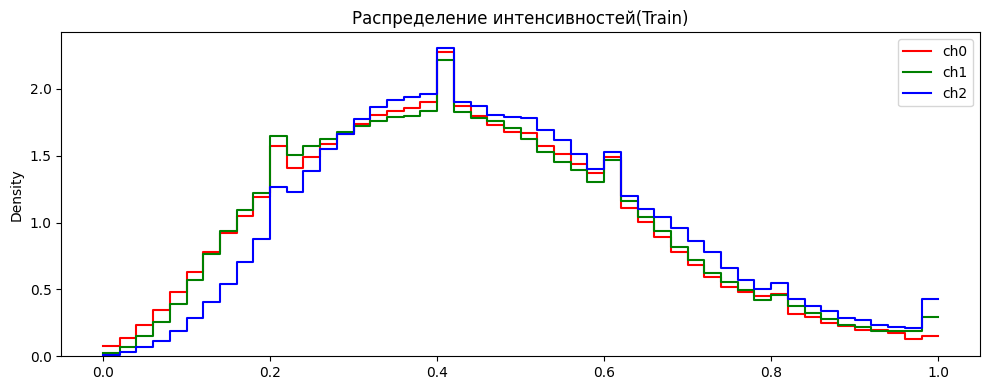

In [6]:
plot_channel_histograms(train_eda, num_samples=4000, phase="Train")

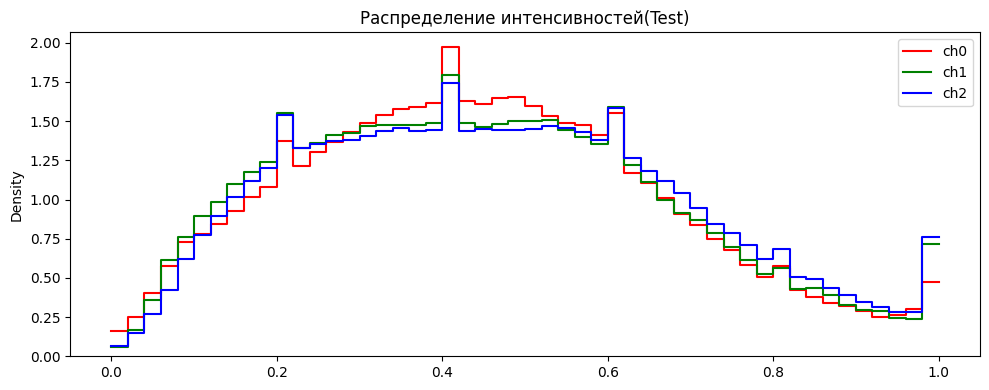

In [8]:
plot_channel_histograms(test_eda, num_samples=4000, phase="Test")

Пик 0.4–0.45 — у большинства пикселей яркость средняя (не тёмные и не очень светлые). Немного прослеживается, что синий канал В чаще чуть ярче (уличные сцены, синеватые таблички). Надо будет нормализовать каждый канал по своему среднему/стандартному отклонению, не одним числом на все каналы

In [9]:
bright, contr, sharp = compute_brightness_contrast_sharpness(train_eda, num_samples=4000)

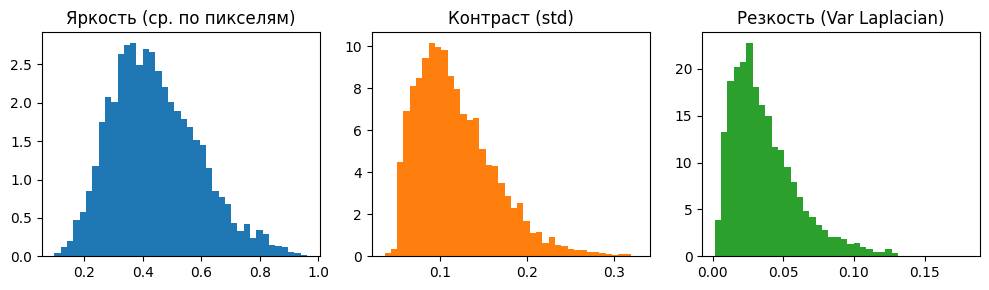

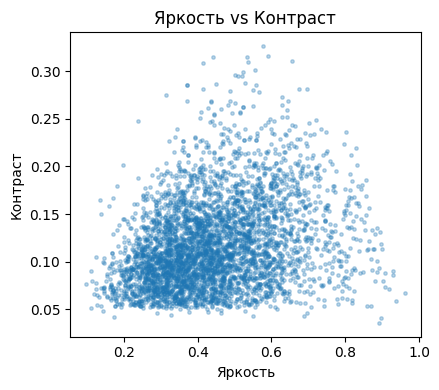

In [10]:
plot_brightness_contrast_sharpness(bright, contr, sharp)

Есть доля низкоконтрастных и мягких (размытых) кадров. Для базовой модели это источник ошибок, логичным будут аугментации типа небольшого blur/noise и contrast/brightness

Яркость vs Контраст: большой разброс значений, явной сильной корреляции нет. Модель должна быть устойчива к независимым изменениям экспозиции и контраста

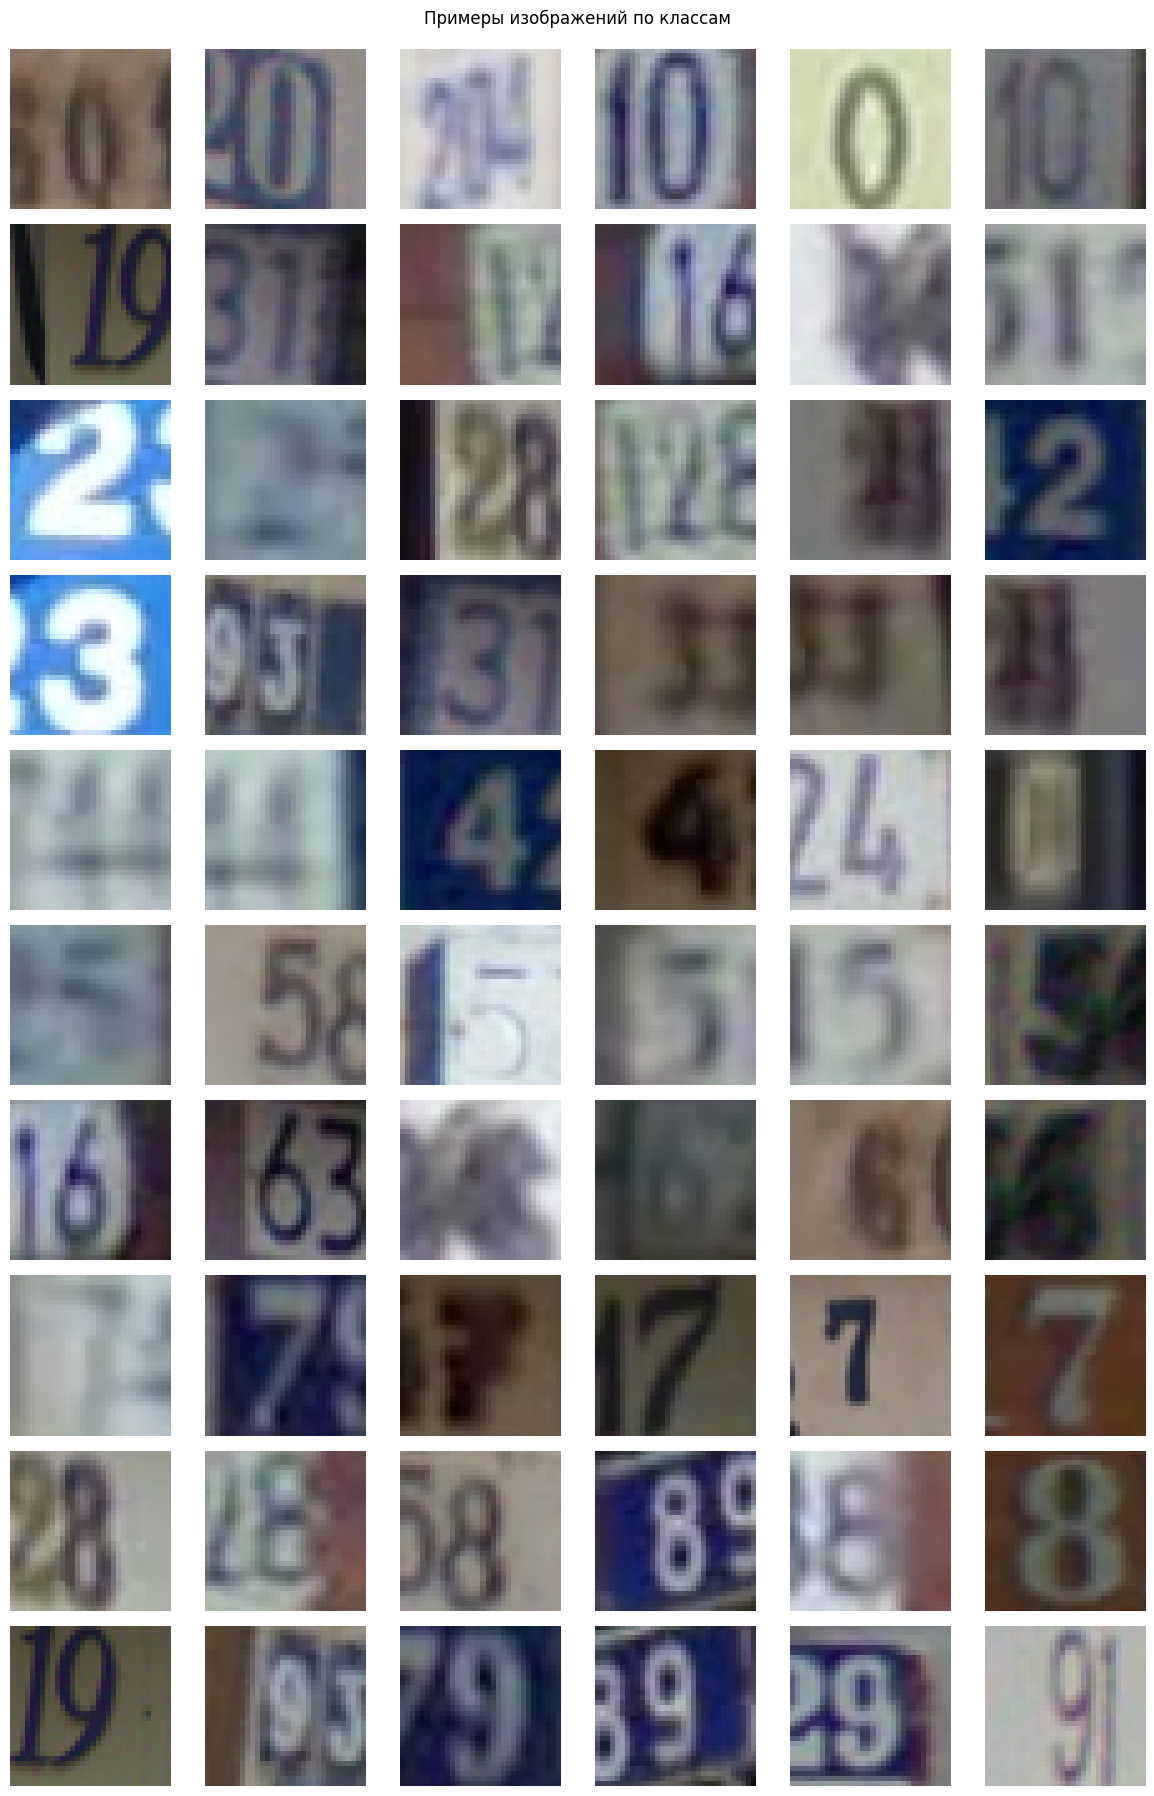

In [11]:
show_examples_per_class(train_eda, classes=list(range(10)), samples_per_class=6)

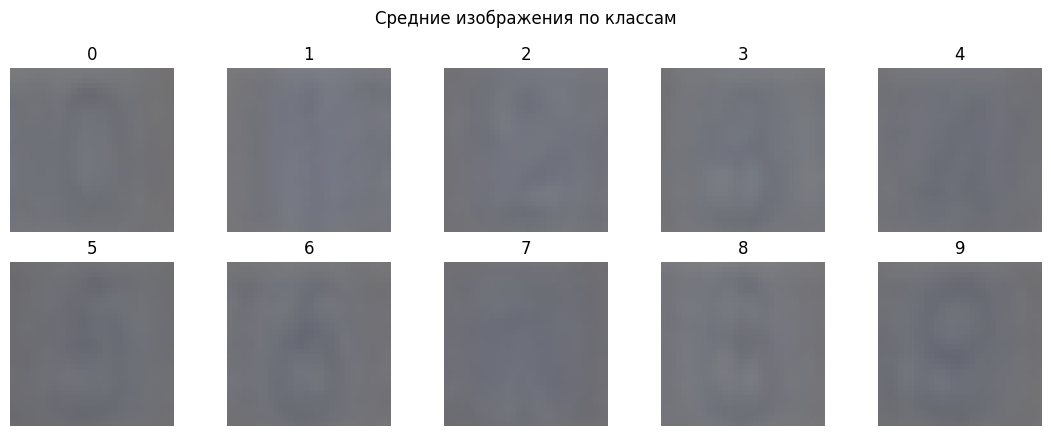

In [12]:
plot_class_means(train_eda)

Цифры в среднем центрированы. Видны характерные фоны/цветовые оттенки, поэтому есть риск утечки контекстных подсказок. Аугментации по цвету и кропы помогут снизить зависимость от фона

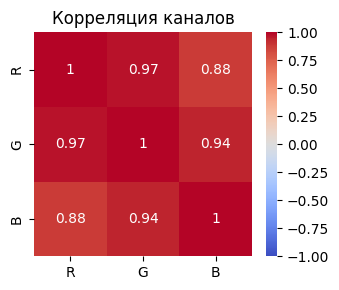

array([[1.        , 0.96944749, 0.88127399],
       [0.96944749, 1.        , 0.94031049],
       [0.88127399, 0.94031049, 1.        ]])

In [13]:
channel_correlations(train_eda, num_samples=4000)

Каналы RGB сильно коррелируют: форма цифры уже хорошо распознаётся по яркостям, поэтому в градациях серого (1 канал) модель тоже будет работать приемлемо. Но цвет всё равно даёт доп сигналы (синий фон, оттенки) и обычно повышает точность